In [91]:
import importlib
import data_preprocessing, midi_conversion, model_helpers, models

importlib.reload(data_preprocessing)
importlib.reload(midi_conversion)
importlib.reload(model_helpers)
importlib.reload(models)


<module 'models' from 'd:\\classical-music-generation-model\\models.py'>

In [25]:
from data_preprocessing import get_midis_by_composer

composers = ["mozart", "haydn"]
midis = get_midis_by_composer(composers)


Now loading MIDIs from data\train.
Could not load data\train\mozart-piano_sonatas-nueva_carpeta-k281_piano_sonata_n03_3mov.mid: Could not decode key with 2 flats and mode 2
Could not load data\train\unknown_artist-i_o-mozart_k550.mid: MThd not found. Probably not a MIDI file
Loaded 311 MIDI files from data\train
Now loading MIDIs from data\val.
Loaded 29 MIDI files from data\val
Now loading MIDIs from data\test.
Could not load data\test\unknown_artist-i_o-mozart_q1_2.mid: MThd not found. Probably not a MIDI file
Loaded 28 MIDI files from data\test
368 MIDI files retrieved.


In [12]:
from data_preprocessing import process_midis_to_images
import os

train_midis, val_midis, test_midis = midis

# Extract just the MidiFile objects (not composer strings)
train_midi_objs = [m for (m, c) in train_midis]

# Convert all train MIDIs to images
train_images = process_midis_to_images(train_midi_objs)

# Save the images
output_path = "generated/train_images_smaller"
os.makedirs(output_path, exist_ok=True)
for i, img in enumerate(train_images):
    img.save(os.path.join(output_path, f"train_window_{i:03d}.png"))

# Repeat process for validation and testing images
val_midi_objs = [m for (m, c) in val_midis]
val_images = process_midis_to_images(val_midi_objs)
output_path = "generated/val_images_smaller"
os.makedirs(output_path, exist_ok=True)
for i, img in enumerate(val_images):
    img.save(os.path.join(output_path, f"val_window_{i:03d}.png"))

test_midi_objs = [m for (m, c) in test_midis]
test_images = process_midis_to_images(test_midi_objs)
output_path = "generated/test_images_smaller"
os.makedirs(output_path, exist_ok=True)
for i, img in enumerate(test_images):
    img.save(os.path.join(output_path, f"test_window_{i:03d}.png"))

Successfully processed 311 MIDIs into 13994 images.
Successfully processed 29 MIDIs into 1336 images.
Successfully processed 28 MIDIs into 1305 images.


In [89]:
from data_preprocessing import PianoRollDataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torch

train_dataset = PianoRollDataset("generated/train_images_smaller")

N = 1200
perm = torch.randperm(len(train_dataset))[:N]
subset = Subset(train_dataset, perm.tolist())
print(f"Reduced to {len(subset)} random images.")

train_loader = DataLoader(subset, batch_size=24, shuffle=True)

Found 13994 images in generated/train_images_smaller
Reduced to 1200 random images.


cuda

Generating example every 20 epochs.


Group 1/10: 100%|██████████| 20/20 [00:56<00:00,  2.82s/it, loss=0.1228]



Epoch 20: Loss = 0.1228


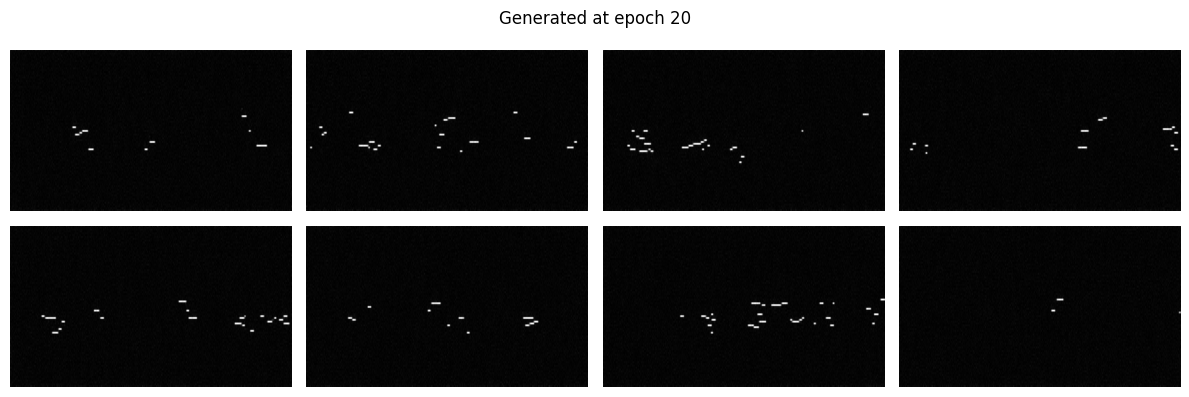


Saved checkpoint to models/diffusion_checkpoints\diffusion_epoch_0020.pt


Group 2/10: 100%|██████████| 20/20 [00:56<00:00,  2.81s/it, loss=0.0791]



Epoch 40: Loss = 0.0791


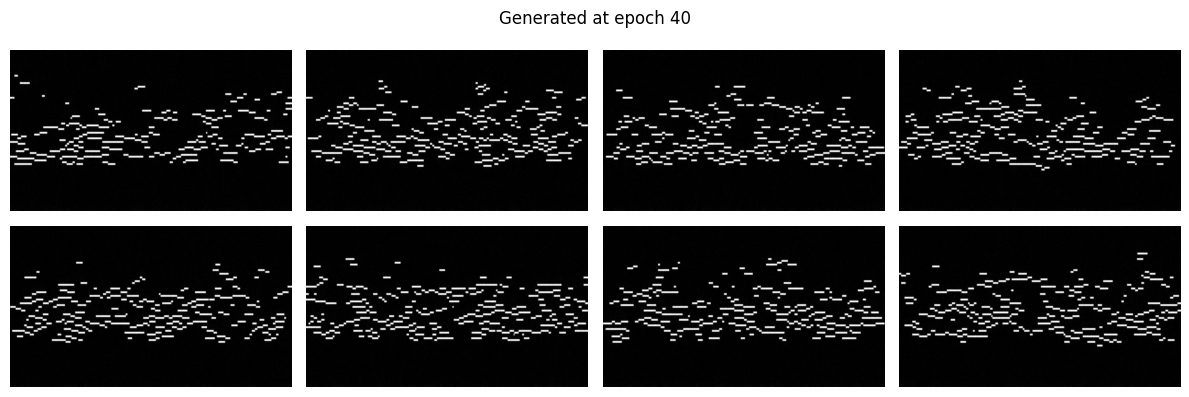


Saved checkpoint to models/diffusion_checkpoints\diffusion_epoch_0040.pt


Group 3/10: 100%|██████████| 20/20 [00:56<00:00,  2.82s/it, loss=0.0572]



Epoch 60: Loss = 0.0572


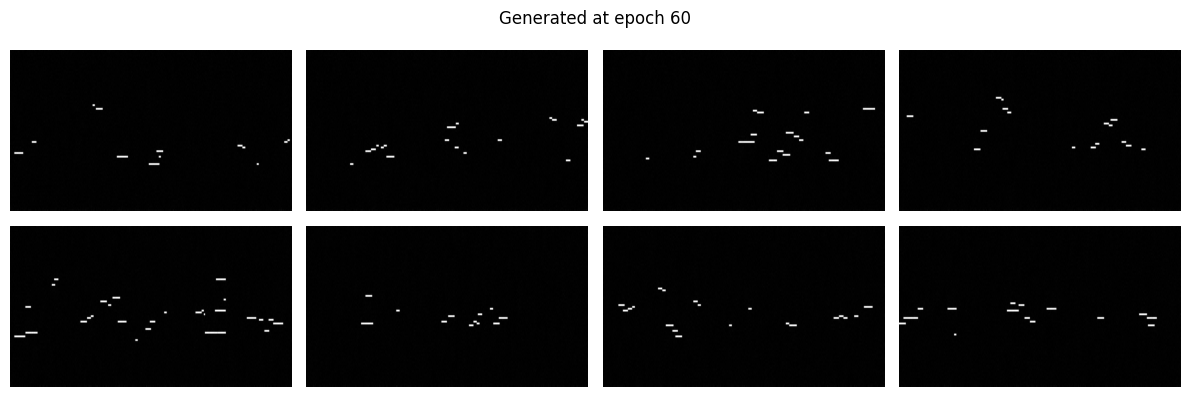


Saved checkpoint to models/diffusion_checkpoints\diffusion_epoch_0060.pt


Group 4/10: 100%|██████████| 20/20 [00:56<00:00,  2.81s/it, loss=0.0478]



Epoch 80: Loss = 0.0478


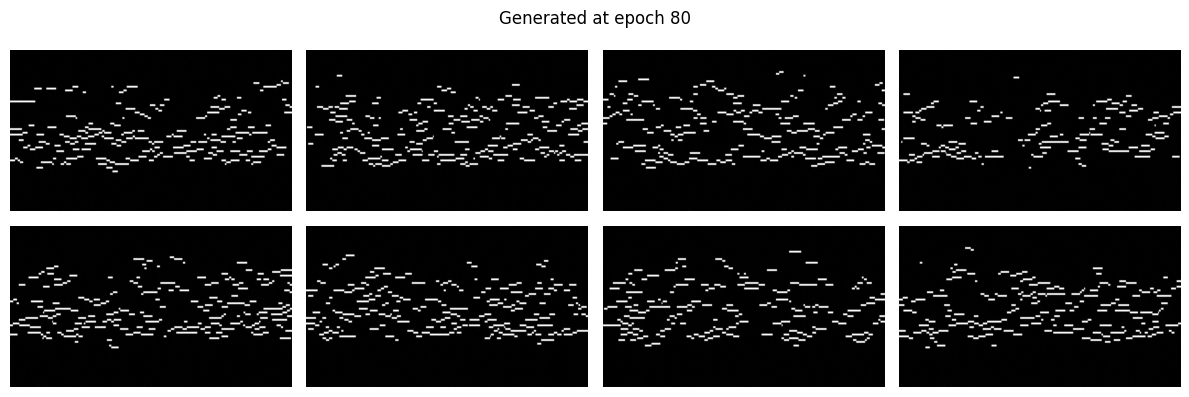


Saved checkpoint to models/diffusion_checkpoints\diffusion_epoch_0080.pt


Group 5/10: 100%|██████████| 20/20 [00:56<00:00,  2.81s/it, loss=0.0427]



Epoch 100: Loss = 0.0427


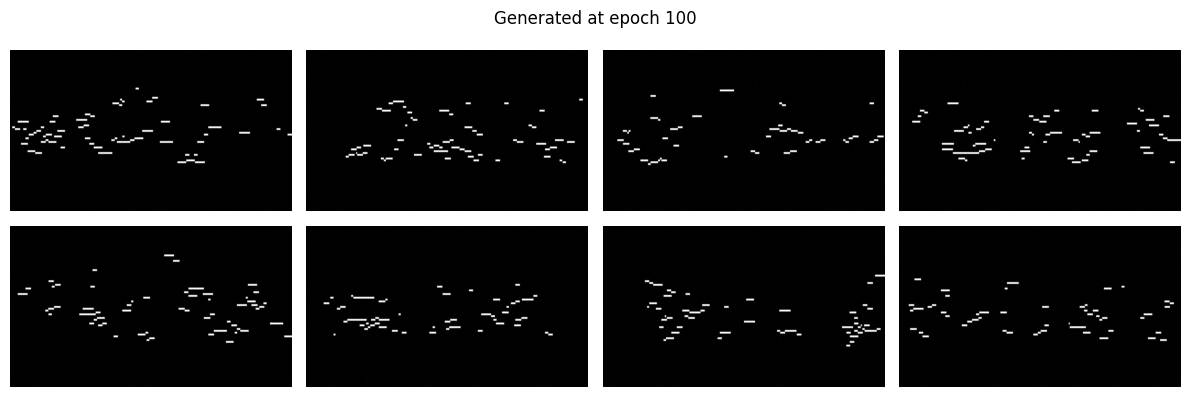


Saved checkpoint to models/diffusion_checkpoints\diffusion_epoch_0100.pt


Group 6/10: 100%|██████████| 20/20 [00:56<00:00,  2.81s/it, loss=0.0392]



Epoch 120: Loss = 0.0392


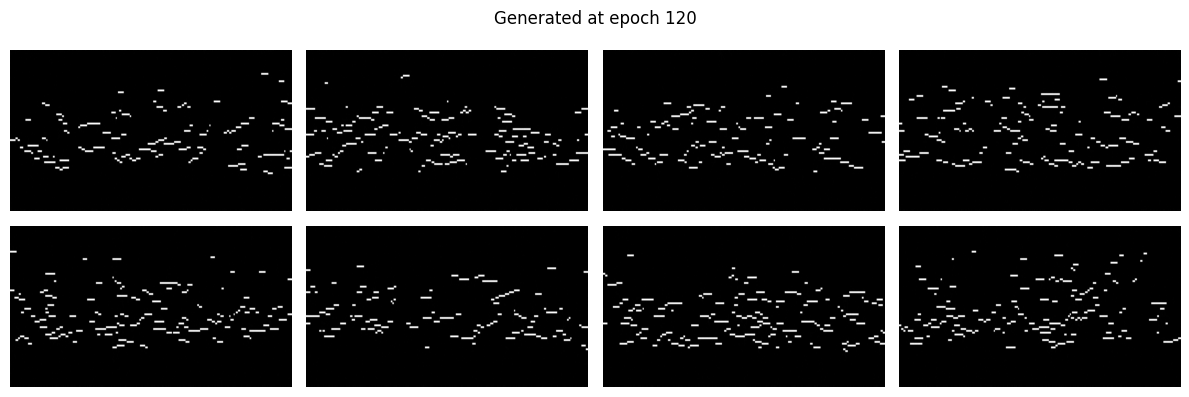


Saved checkpoint to models/diffusion_checkpoints\diffusion_epoch_0120.pt


Group 7/10: 100%|██████████| 20/20 [00:56<00:00,  2.83s/it, loss=0.0359]



Epoch 140: Loss = 0.0359


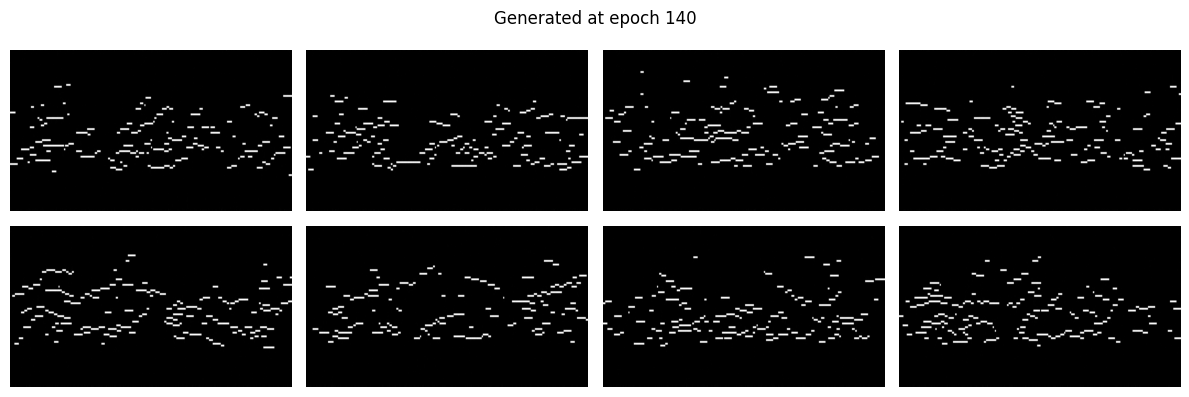


Saved checkpoint to models/diffusion_checkpoints\diffusion_epoch_0140.pt


Group 8/10: 100%|██████████| 20/20 [00:56<00:00,  2.81s/it, loss=0.0297]



Epoch 160: Loss = 0.0297


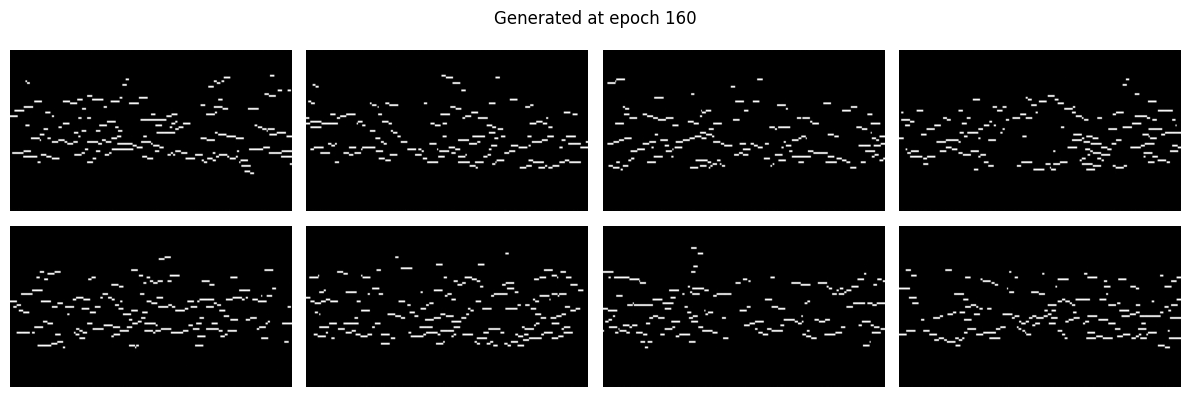


Saved checkpoint to models/diffusion_checkpoints\diffusion_epoch_0160.pt


Group 9/10: 100%|██████████| 20/20 [00:56<00:00,  2.81s/it, loss=0.0284]



Epoch 180: Loss = 0.0284


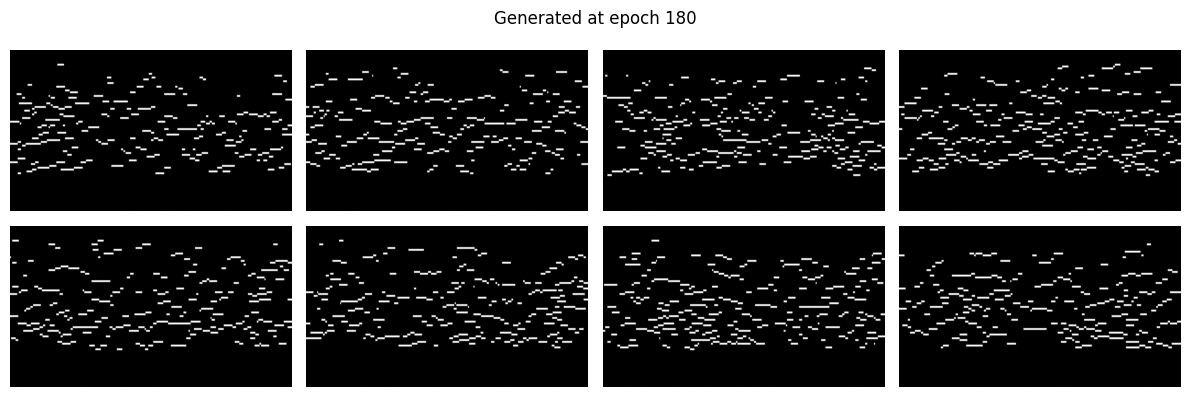


Saved checkpoint to models/diffusion_checkpoints\diffusion_epoch_0180.pt


Group 10/10: 100%|██████████| 20/20 [00:56<00:00,  2.81s/it, loss=0.0233]



Epoch 200: Loss = 0.0233


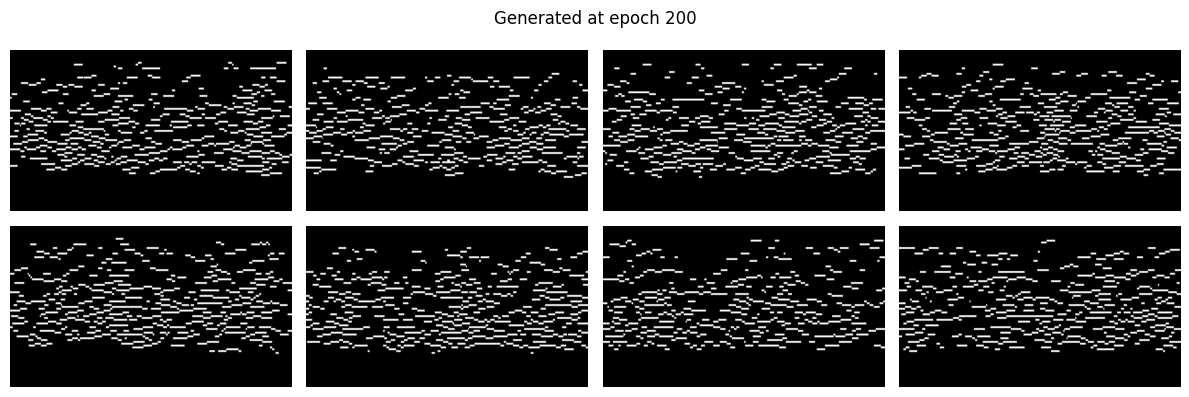


Saved checkpoint to models/diffusion_checkpoints\diffusion_epoch_0200.pt
Training complete!


In [92]:
import torch
from models import SimpleUNet, train_diffusion_model

T = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = SimpleUNet().to(device)

losses = train_diffusion_model(model, train_loader, T, num_epochs=200, lr=5e-5, gen_freq=20, device=device, img_size=[88,256],
                               save_dir="models/diffusion_checkpoints", save_checkpoints=True)


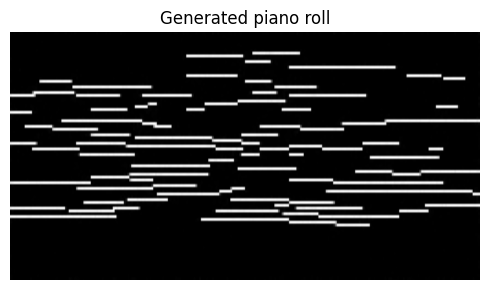

In [93]:
from models import sample_image
from model_helpers import prepare_noise_schedule, show_image_tensor


# SAMPLE image generation from the final-epoch model
_, alphas = prepare_noise_schedule(device, timesteps=T)
sample = sample_image(model, alphas, device, img_size=[88,256])
show_image_tensor(sample, title="Generated piano roll")


In [94]:
from midi_conversion import pianoroll_images_to_midi
import numpy as np
from PIL import Image
import os

sample_01 = (sample + 1.0) / 2.0
sample_01 = sample_01.squeeze(0).cpu().numpy()
sample_img = (sample_01 * 255).astype(np.uint8)
img = Image.fromarray(sample_img, mode="L")

output_path = "generated/"
os.makedirs(output_path, exist_ok=True)
img.save(os.path.join(output_path, f"generated_diffusion_sample.png"))

mid = pianoroll_images_to_midi([img], tempo_bpm=120, time_signature=(4, 4))
mid.save("generated/generated_diffusion_sample.mid")


C:\Users\Calvin\AppData\Local\Temp\ipykernel_27696\3470164361.py:9: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(sample_img, mode="L")
